In [1]:
import numpy as np
from surprise import SVD, Dataset, accuracy
from surprise.model_selection import train_test_split
from elbow_detection import calc_elbow
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
n_users = trainset.n_users
n_items = trainset.n_items
n_ratings = trainset.n_ratings
rating_matrix = np.full((n_users, n_items), np.nan)

for (user_id, item_id, rating) in trainset.all_ratings():
    user_idx = int(user_id)
    item_idx = int(item_id)
    rating_matrix[user_idx, item_idx] = rating

rating_mean = np.nanmean(rating_matrix)

rating_matrix_meaned = np.nan_to_num(rating_matrix, nan=rating_mean) # fill mean for missing
rating_matrix_centered = np.nan_to_num(rating_matrix - rating_mean) # center non-missing around zero


In [3]:
U_m, S_m, VT_m = np.linalg.svd(rating_matrix_meaned)
U_c, S_c, VT_c = np.linalg.svd(rating_matrix_centered)


In [4]:
print(np.mean(rating_matrix_meaned))
print(np.mean(rating_matrix_centered + rating_mean))

3.5318875000000007
3.5318875000000007


4407.437118201214 72.39641816026709


<Axes: >

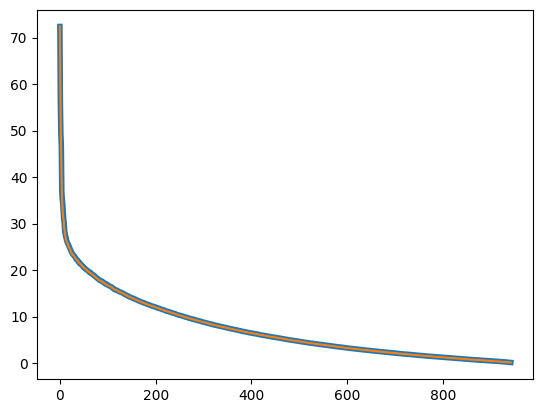

In [5]:
S_m_copy = np.copy(S_m)
S_m_copy[0] = S_c[0]
print(S_m[0], S_c[0])
sns.lineplot(S_m_copy, linewidth=4) # both follow the same contour
sns.lineplot(S_c)

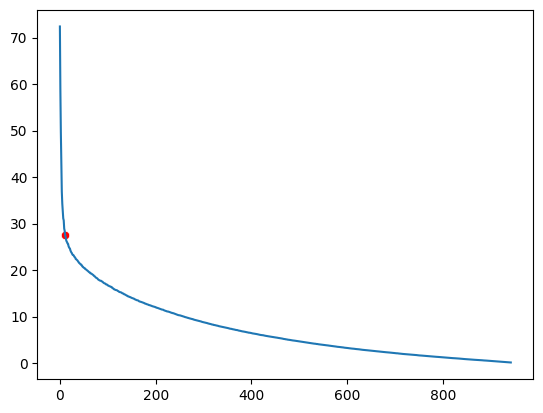

11


In [6]:
k = calc_elbow(S_c, 0.95) #0.6 or 0.95 depending on what graph u use, more clear graph structures require less
sns.lineplot(S_c)
sns.scatterplot(x=[k], y=[S_c[k]], color='red')
plt.show()
print(k)

In [7]:
U_ck = U_c[:,0:k+1]
S_ck = np.diag(S_c[0:k+1])
V_ck = VT_c.T[:,0:k+1]

U_mk = U_m[:,0:k+1]
S_mk = np.diag(S_m[0:k+1])
V_mk = VT_m.T[:,0:k+1]

centered_predict_matrix = (U_ck @ S_ck @ V_ck.T) + rating_mean
meaned_predict_matrix = (U_mk @ S_mk @ V_mk.T)

In [8]:
def calc_pred_error(predict_matrix:np.ndarray, testset:list[tuple], rmse=True):
    true_ratings = []
    pred_ratings = []
    removed_datapoints = 0

    for (uid_raw, iid_raw, true_r) in testset:
        try:
            uid_inner = trainset.to_inner_uid(uid_raw)
            iid_inner = trainset.to_inner_iid(iid_raw)
            pred_r = predict_matrix[uid_inner, iid_inner]
            true_ratings.append(true_r)
            pred_ratings.append(pred_r)
        except:
            removed_datapoints += 1
    ss = np.sum(np.square(np.array(true_ratings) - np.array(pred_ratings)))
    rmse = np.sqrt(ss / len(true_ratings))
    true_rating_mean = np.mean(true_ratings)
    total_ss = np.sum(np.square(np.array(true_ratings) - true_rating_mean))
    r_squared = 1 - ss / total_ss
    print(rmse, r_squared)



In [9]:
# print(calc_pred_error(np.ones(rating_matrix.shape) * rating_mean, testset))

calc_pred_error(centered_predict_matrix, testset)
calc_pred_error(meaned_predict_matrix, testset) # at higher ranks this performs better, lower ranks slightly worse
# print('%d out of %d test data discarded' % (removed_datapoints, len(testset))) # 36 out of 20000


1.0397310114942933 0.15143853966818677
1.040432291681145 0.1502934742269849


In [10]:
from sklearn.metrics import r2_score

model = SVD(n_factors=k, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Fit
model.fit(trainset)

# Predict on test set
predictions = model.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions, verbose=False)
# Extract true and predicted ratings from the Surprise predictions
y_true = [pred.r_ui for pred in predictions]   # true rating
y_pred = [pred.est for pred in predictions]    # predicted rating

# Compute R²
r_squared = r2_score(y_true, y_pred, )
print(rmse, r_squared)

0.9366822057110749 0.31317124389686335
